In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt 
import pickle
import tensorly
import matplotlib.ticker as ticker
import tensorsketch
from tensorsketch.tensor_approx import TensorApprox
import warnings
warnings.filterwarnings('ignore')
from plot_util import *

'''
The dataset can be downloaded from:
PSL(sea level pressure): https://www.earthsystemgrid.org/dataset/ucar.cgd.ccsm4.CESM_CAM5_BGC_LE.atm.proc.monthly_ave.PSL/file.html
BURDENDUST(Dust aerosol burden): https://www.earthsystemgrid.org/dataset/ucar.cgd.ccsm4.CESM_CAM5_BGC_LE.atm.proc.monthly_ave.BURDENDUST.html
CLOUD(cloud fraction): https://www.earthsystemgrid.org/dataset/ucar.cgd.ccsm4.CESM_CAM5_BGC_LE.atm.proc.monthly_ave.CLOUD/file.html
AODABS(Aerosol absorption optical depth 550 nm): https://www.earthsystemgrid.org/dataset/ucar.cgd.ccsm4.CESM_CAM5_BGC_LE.atm.proc.monthly_ave.AODABS/file.html
ABSORB(Aerosol absorption): https://www.earthsystemgrid.org/dataset/ucar.cgd.ccsm4.CESM_CAM5_BGC_LE.atm.proc.monthly_ave.ABSORB/file.html
SRFRAD(Net radiative flux at surface): https://www.earthsystemgrid.org/dataset/ucar.cgd.ccsm4.CESM_CAM5_BGC_LE.atm.proc.monthly_ave.SRFRAD/file.html
'''
#CLOUD = nc.Dataset("data/b.e11.BRCP85C5CNBDRD.f09_g16.013.cam.h0.CLOUD.208101-210012.nc").variables['CLOUD'][:]
AODABS = nc.Dataset("data/b.e11.B1850C5CN.f09_g16.005.cam.h0.AODABS.040001-049912.nc").variables['AODABS'][:] 
AODABS = AODABS.filled(AODABS.mean())
ABSORB = nc.Dataset("data/b.e11.BRCP85C5CNBDRD.f09_g16.023.cam.h0.ABSORB.208101-210012.nc").variables['ABSORB'][:]
ABSORB = ABSORB.filled(ABSORB.mean())
SRFRAD = nc.Dataset("data/b.e11.B1850C5CN.f09_g16.005.cam.h0.SRFRAD.040001-049912.nc").variables['SRFRAD'][:]
BURDENDUST = nc.Dataset("data/b.e11.B1850C5CN.f09_g16.005.cam.h0.BURDENDUST.040001-049912.nc").variables['BURDENDUST'][:] 
#PSL = nc.Dataset("data/b.e11.B1850C5CN.f09_g16.005.cam.h0.PSL.200001-209912.nc").variables['PSL'][:]

def simrun_name(name, inv_factor, typ, tensor_proj): 
    ''' 
    Create an file name for a simulation run
    '''
    if tensor_proj: 
      t = "prod"
    else:
      t = ""
    
    return "data/"+name+"_frk"+str(inv_factor)+"_"+typ+t+".pickle"

Using numpy backend.
Using numpy backend.


In [12]:
def multisimplot_name(name, inv_factor): 
    return "plots/journal/"+"multi_"+name+"_frk"+str(inv_factor)+".pdf" 
def multiplot_realdata_frk(rm_typs , data, inv_factor, name, fontsize = 28): 
    np.random.seed(1)
    ranks = (np.array(data.shape)/inv_factor).astype(int)    
    kratio = np.arange(2/inv_factor,2/5, (2/5 -1/inv_factor)/10)    
    plt.figure(figsize=(6,5))
    set_plot(fontsize)
    sim_list = []
    alldata = []
    
    for i,rm_typ in enumerate(rm_typs):        
        sim_list.append(pickle.load(open(simrun_name(name, inv_factor, rm_typ[0], rm_typ[1]), "rb" )))
        hooi_result = np.array([(sim_list[i][0][j]) for j in range(len(sim_list[i][0]))])
        st_hosvd_result = np.array([(sim_list[i][1][j]) for j in range(len(sim_list[i][0]))])
        two_pass_result = np.array([(sim_list[i][2][j]) for j in range(len(sim_list[i][0]))])
        one_pass_result = np.array([(sim_list[i][3][j]) for j in range(len(sim_list[i][0]))]) 
        plt.plot(kratio,hooi_result, label = find_rm_label(rm_typ[0]+("prod" if rm_typ[1] else ""))+' HOOI', markersize = 10, marker = marker('hooi', 'gprod'), color = marker_color('hooi', 'gprod') ,markeredgewidth=1, markerfacecolor='None') 
        plt.plot(kratio,st_hosvd_result, label = find_rm_label(rm_typ[0]+("prod" if rm_typ[1] else ""))+' ST-HOSVD', markersize = 10, marker = marker('st-hosvd', 'gprod'), color = marker_color('st-hosvd', 'gprod') ,markeredgewidth=1, markerfacecolor='None') 
        plt.plot(kratio,two_pass_result, label = find_rm_label(rm_typ[0]+("prod" if rm_typ[1] else ""))+' 2-Pass', markersize = 10, marker = marker('2pass', 'gprod'), color = marker_color('2pass', 'gprod') ,markeredgewidth=1, markerfacecolor='None') 
        plt.plot(kratio,one_pass_result, label = find_rm_label(rm_typ[0]+("prod" if rm_typ[1] else ""))+' 1-Pass', markersize = 10, marker = marker('1pass', 'gprod'), color = marker_color('1pass', 'gprod') ,markeredgewidth=1, markerfacecolor='None') 
        alldata.append(two_pass_result)
        alldata.append(one_pass_result)
    plt.yscale('log')
    if inv_factor == 15: 
        plt.legend(loc = 'best', bbox_to_anchor=(1, 0.85))
    alldata = np.concatenate(alldata)
    ymax = np.max(alldata)*2
    ymin = np.min(alldata)/2
    #ymax = 10**(np.log10(ymax))
    #ymin = 10**(np.log10(ymin))
    plt.ylim(ymin, ymax)
    compression_ratio = int(np.product(data.shape)/(np.sum(np.array(data.shape)*ranks)+np.product(ranks)))
    plt.title(''.join([r'$\times$',str(compression_ratio), ' Compression']), fontsize = fontsize)
    plt.xlabel('k/I')
    plt.ylabel('Relative Error')
    plt.savefig(multisimplot_name(name,inv_factor),bbox_inches = "tight",pad_inches=0)
    plt.show()

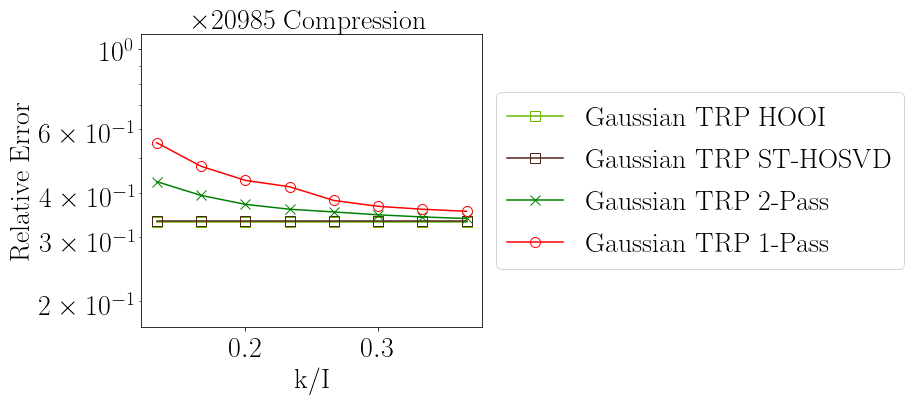

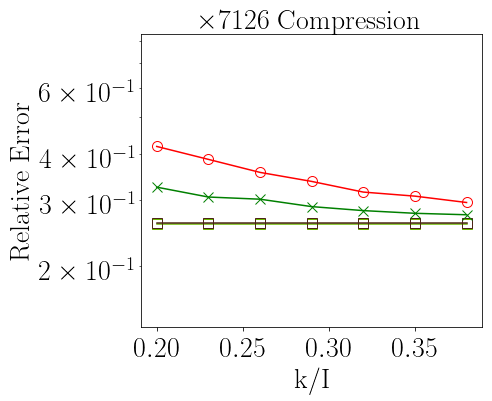

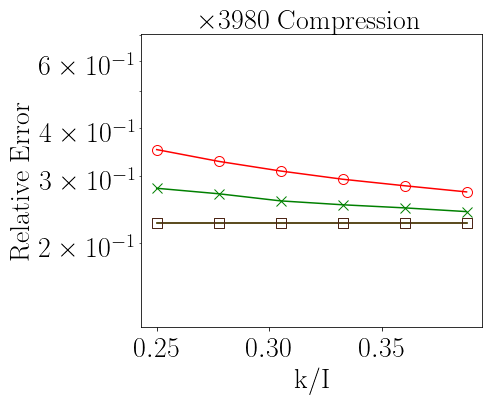

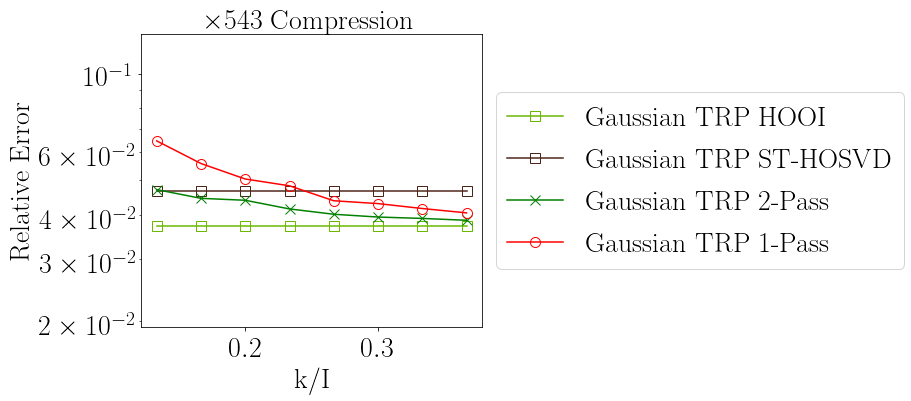

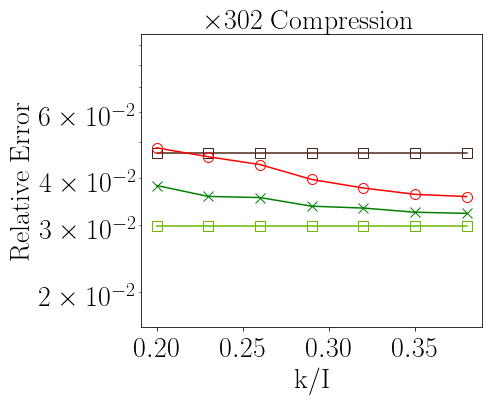

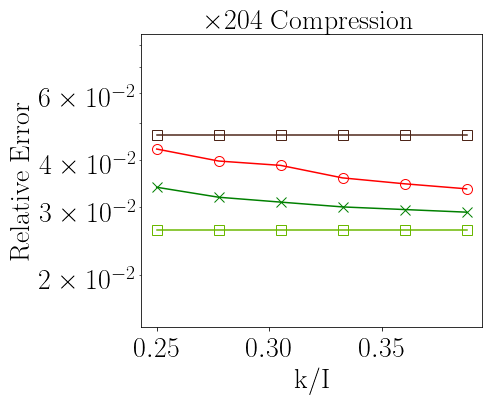

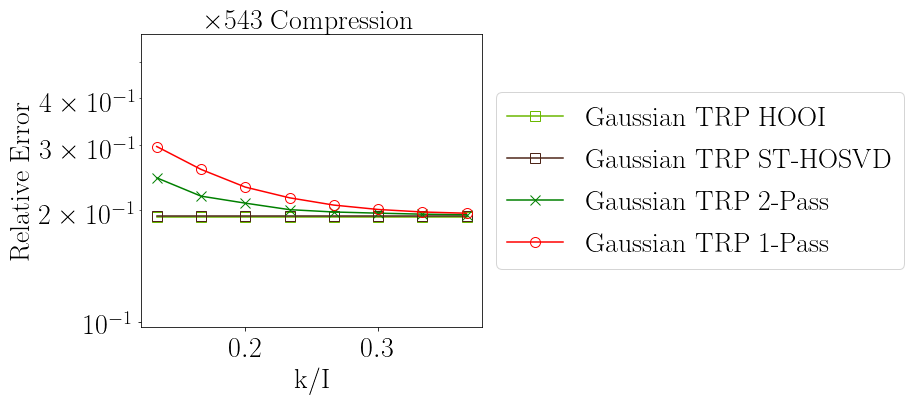

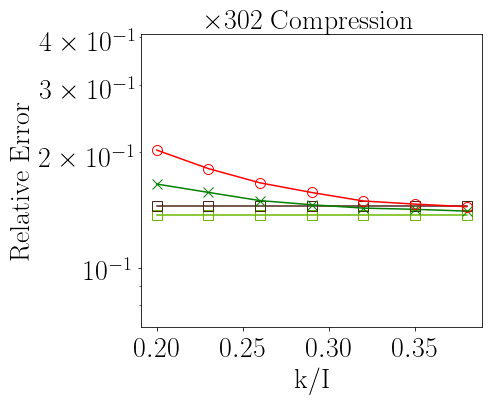

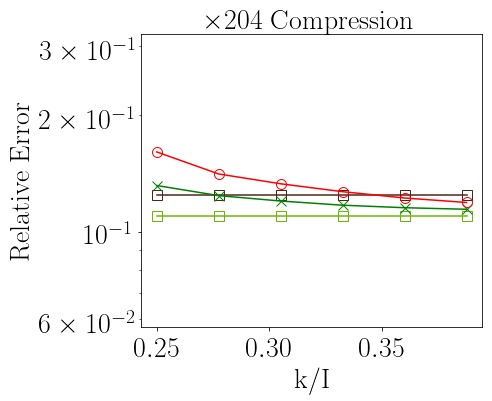

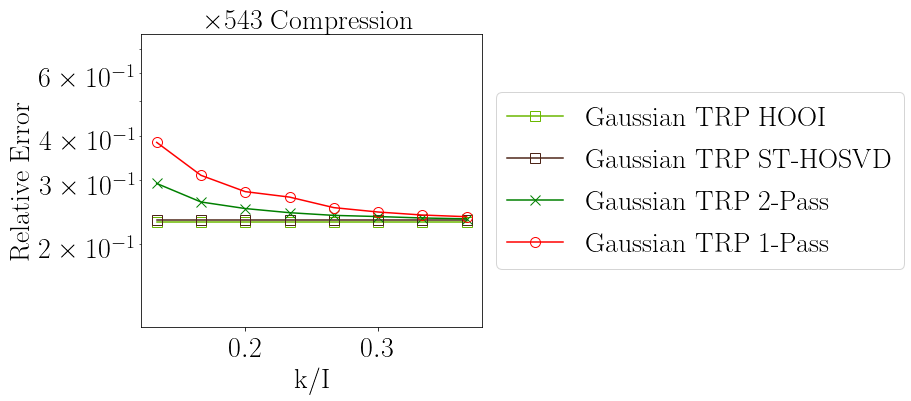

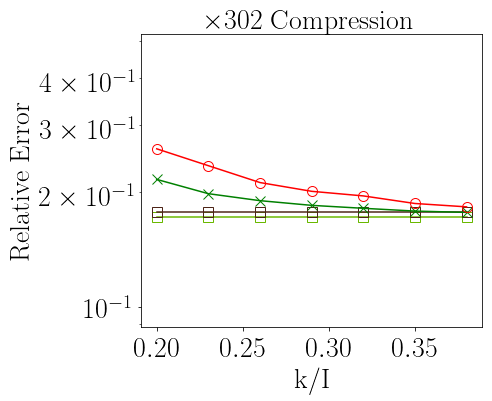

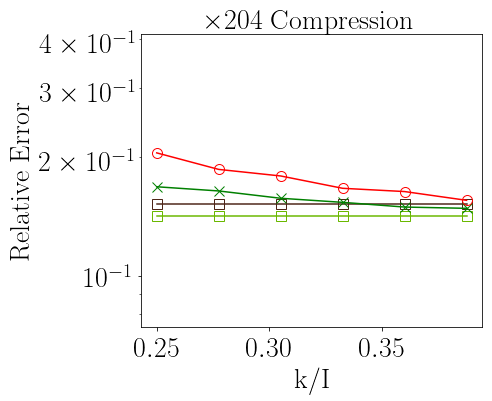

In [13]:
multiplot_realdata_frk([('g', True)], ABSORB,15,"ABSORB")
multiplot_realdata_frk([('g', True)], ABSORB,10,"ABSORB")
multiplot_realdata_frk([('g', True)], ABSORB,8,"ABSORB")
multiplot_realdata_frk([('g', True)], SRFRAD,15,"SRFRAD")
multiplot_realdata_frk([('g', True)], SRFRAD,10,"SRFRAD")
multiplot_realdata_frk([('g', True)], SRFRAD,8,"SRFRAD")
multiplot_realdata_frk([('g', True)], BURDENDUST,15,"BURDENDUST")
multiplot_realdata_frk([('g', True)], BURDENDUST,10,"BURDENDUST")
multiplot_realdata_frk([('g', True)], BURDENDUST,8,"BURDENDUST")
multiplot_realdata_frk([('g', True)], AODABS,15,"AODABS")
multiplot_realdata_frk([('g', True)], AODABS,10,"AODABS")
multiplot_realdata_frk([('g', True)], AODABS,8,"AODABS")